## One-time


In [1]:
import os
assert os.environ['COLAB_TPU_ADDR']
VERSION = "20200606"  #@param ["1.5" , "20200516", "20200606","nightly"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version $VERSION # --apt-packages libomp5 libopenblas-dev


In [2]:
%%time
!pip uninstall kaggle -y
!pip install kaggle==1.5.6 -q
!pip install -U catalyst -q
!pip install -U git+https://github.com/albu/albumentations -q
!pip install -U git+https://github.com/rwightman/pytorch-image-models -q
!pip install -U git+https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer -q

!mkdir ~/.kaggle/
!cp ./kaggle.json  ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d shonenkov/melanoma-merged-external-data-512x512-jpeg
!unzip melanoma-merged-external-data-512x512-jpeg.zip -d ./data/ &> /dev/null
!rm melanoma-merged-external-data-512x512-jpeg.zip
!kaggle competitions download siim-isic-melanoma-classification -f sample_submission.csv
!kaggle competitions download siim-isic-melanoma-classification -f test.csv
!kaggle competitions download siim-isic-melanoma-classification -f train.csv
!unzip train.csv -d ./data/ &> /dev/null
!mv ./test.csv ./data/ 
!mv ./sample_submission.csv ./data/
!rm train.csv.zip
!mkdir ./logs/

CPU times: user 1e+03 ns, sys: 2 µs, total: 3 µs
Wall time: 6.91 µs


## Setup

In [4]:
import os
import gc
import time
import datetime
import random

#os.environ['XLA_USE_BF16'] = "0"

import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models

import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.utils.serialization as xser
import torch_xla.debug.metrics as met
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.utils.utils as xu
from torch.utils.data.distributed import DistributedSampler
from torch.utils.tensorboard import SummaryWriter

from ranger import Ranger

#from catalyst.data.sampler import DistributedSamplerWrapper, BalanceClassSampler
import timm

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    xm.set_rng_state(seed, device=xm.xla_device())

DATA_DIR = '/content/data/'
df_train = pd.read_csv(DATA_DIR+'folds_13062020.csv')
df_test = pd.read_csv(DATA_DIR+'test.csv').rename(columns={'image_name':'image_id'})
sample_submission = pd.read_csv(DATA_DIR+'sample_submission.csv')

## Dataset

In [7]:
class MelanomaDataset(Dataset):

    def __init__(self, df, labels, istrain=False, transforms=None):
        super().__init__()
        self.image_id = df['image_id'].values
        self.transforms = transforms
        self.labels = labels.values
        self.neg_indices = np.where(self.labels[:, 0] == 0)[0]
        self.pos_indices = np.where(self.labels[:, 0] == 1)[0]
        self.istrain = istrain

    def __len__(self):
        return len(self.image_id)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()

        image, target = self.load_image(index)

        if self.transforms:
            image = self.transforms(image=image)['image']

        return image, target

    def load_image(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        image_name = DATA_DIR + f'512x512-dataset-melanoma/512x512-dataset-melanoma/{self.image_id[index]}.jpg'
        image = cv2.imread(image_name, cv2.IMREAD_COLOR).astype(np.uint8)
        target = self.labels[index].astype(np.float32)
        return image, target


def get_datasets(data):
    X_train, y_train, X_val, y_val = data
    datasets = {}
    datasets['train'] = MelanomaDataset(
        X_train, y_train, istrain=True, transforms=get_train_transforms()
    )
    datasets['valid'] = MelanomaDataset(
        X_val, y_val, istrain=False, transforms=get_valid_transforms()
    )
    return datasets


## Augmentations

In [8]:
from albumentations.augmentations import functional as FA
from albumentations.core.transforms_interface import DualTransform

class GridMask(DualTransform):
    def __init__(self, num_grid=3, fill_value=0, rotate=0, mode=0, always_apply=False, p=0.5):
        super(GridMask, self).__init__(always_apply, p)
        if isinstance(num_grid, int):
            num_grid = (num_grid, num_grid)
        if isinstance(rotate, int):
            rotate = (-rotate, rotate)
        self.num_grid = num_grid
        self.fill_value = fill_value
        self.rotate = rotate
        self.mode = mode
        self.masks = None
        self.rand_h_max = []
        self.rand_w_max = []

    def init_masks(self, height, width):
        if self.masks is None:
            self.masks = []
            n_masks = self.num_grid[1] - self.num_grid[0] + 1
            for n, n_g in enumerate(range(self.num_grid[0], self.num_grid[1] + 1, 1)):
                grid_h = height / n_g
                grid_w = width / n_g
                this_mask = np.ones((int((n_g + 1) * grid_h), int((n_g + 1) * grid_w))).astype(np.uint8)
                for i in range(n_g + 1):
                    for j in range(n_g + 1):
                        this_mask[
                             int(i * grid_h) : int(i * grid_h + grid_h / 2),
                             int(j * grid_w) : int(j * grid_w + grid_w / 2)
                        ] = self.fill_value
                        if self.mode == 2:
                            this_mask[
                                 int(i * grid_h + grid_h / 2) : int(i * grid_h + grid_h),
                                 int(j * grid_w + grid_w / 2) : int(j * grid_w + grid_w)
                            ] = self.fill_value
                
                if self.mode == 1:
                    this_mask = 1 - this_mask

                self.masks.append(this_mask)
                self.rand_h_max.append(grid_h)
                self.rand_w_max.append(grid_w)

    def apply(self, image, mask, rand_h, rand_w, angle, **params):
        h, w = image.shape[:2]
        mask = FA.rotate(mask, angle) if self.rotate[1] > 0 else mask
        mask = mask[:,:,np.newaxis] if image.ndim == 3 else mask
        image *= mask[rand_h:rand_h+h, rand_w:rand_w+w].astype(image.dtype)
        return image

    def get_params_dependent_on_targets(self, params):
        img = params['image']
        height, width = img.shape[:2]
        self.init_masks(height, width)

        mid = np.random.randint(len(self.masks))
        mask = self.masks[mid]
        rand_h = np.random.randint(self.rand_h_max[mid])
        rand_w = np.random.randint(self.rand_w_max[mid])
        angle = np.random.randint(self.rotate[0], self.rotate[1]) if self.rotate[1] > 0 else 0

        return {'mask': mask, 'rand_h': rand_h, 'rand_w': rand_w, 'angle': angle}

    @property
    def targets_as_params(self):
        return ['image']

    def get_transform_init_args_names(self):
        return ('num_grid', 'fill_value', 'rotate', 'mode')

In [9]:
#%%writefile augmentations.txt
# Reference IMG_SIZE
# B0    - 224
# B1    - 240
# B2    - 260
# B3    - 300
# B4    - 380
# B5    - 456
# B6    - 520
# B7    - 600
# B8    - 672
# L2 NS - 475
# L2    - 800
IMG_SIZE = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

def get_train_transforms(p=1.0):
    return A.Compose(
        [
            A.OneOf(
                [
                    A.CenterCrop(2 * IMG_SIZE // 3, 2 * IMG_SIZE // 3, p=0.5),
                    A.CenterCrop(3 * IMG_SIZE // 4, 3 * IMG_SIZE // 4, p=0.5),
                ],
                p=0.33,
            ),
            A.Resize(
                IMG_SIZE, IMG_SIZE, interpolation=1, always_apply=True, p=1
            ),
            A.Flip(),
            A.Transpose(),
            GridMask(num_grid=(1, 4), rotate=15, p=0.33),
            A.OneOf(
                [
                    A.MedianBlur(blur_limit=3, p=0.5),
                    A.Blur(blur_limit=3, p=0.5),
                ],
                p=0.5,
            ),
            A.OneOf(
                [
                    A.ShiftScaleRotate(
                        interpolation=1,
                        shift_limit=0.05,
                        scale_limit=0.1,
                        rotate_limit=15,
                        p=0.5,
                    ),
                    A.IAAPiecewiseAffine(scale=(0.02, 0.04), p=0.5),
                ],
                p=0.33,
            ),
            A.OneOf(
                [
                    A.HueSaturationValue(
                        hue_shift_limit=20,
                        sat_shift_limit=30,
                        val_shift_limit=20,
                        p=0.5,
                    ),
                    A.RandomBrightnessContrast(p=0.5),
                ],
                p=0.5,
            ),
            A.MultiplicativeNoise(
                multiplier=[0.9, 1.1], elementwise=True, p=0.3
            ),
            A.Normalize(mean, std, max_pixel_value=255.0, always_apply=True),
            ToTensorV2(p=1.0),
        ],
        p=p,
    )

def get_valid_transforms():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE, interpolation=2, always_apply=True, p=1),
        A.Normalize(mean, std, max_pixel_value=255.0, always_apply=True),
        ToTensorV2(p=1.0),
    ])


## Model

In [10]:
def gem(x, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)

class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = Parameter(torch.ones(1)*p)
        self.eps = eps
    def forward(self, x):
        return gem(x, p=self.p, eps=self.eps)       
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'


In [11]:
class EfficientNet(nn.Module):

    def __init__(self, name='tf_efficientnet_b0_ns'):
        super().__init__()
        self.model = timm.create_model(name, pretrained=True)
        #self.model.global_pool = GeM()
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(in_features, 1)

    def forward(self, x):
        return self.model(x)

class SEResNext50_32x4d(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = timm.create_model('gluon_seresnext50_32x4d', pretrained=True)
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, 2)

    def forward(self, x):
        return self.model(x)

class SEResNext101_32x4d(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = timm.create_model('gluon_seresnext101_32x4d', pretrained=True)
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, 2)

    def forward(self, x):
        return self.model(x)


## Custom Losses

In [12]:
from torch.nn import functional as F

def sigmoid_focal_loss(
    inputs: torch.Tensor,
    targets: torch.Tensor,
    alpha: float = 0.91,
    gamma: float = 1.65,
    reduction: str = "mean"
) -> torch.Tensor:
    """
    Loss used in RetinaNet for dense detection: https://arxiv.org/abs/1708.02002.
    Args:
        inputs: A float tensor of arbitrary shape.
                The predictions for each example.
        targets: A float tensor with the same shape as inputs. Stores the binary
                 classification label for each element in inputs
                (0 for the negative class and 1 for the positive class).
        alpha: (optional) Weighting factor in range (0,1) to balance
                positive vs negative examples. Default = -1 (no weighting).
        gamma: Exponent of the modulating factor (1 - p_t) to
               balance easy vs hard examples.
        reduction: 'none' | 'mean' | 'sum'
                 'none': No reduction will be applied to the output.
                 'mean': The output will be averaged.
                 'sum': The output will be summed.
    Returns:
        Loss tensor with the reduction option applied.
    """
    p = torch.sigmoid(inputs)
    ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
    p_t = p * targets + (1 - p) * (1 - targets)
    loss = ce_loss * ((1 - p_t) ** gamma)

    if alpha >= 0:
        alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
        loss = alpha_t * loss

    if reduction == "mean":
        loss = loss.mean()
    elif reduction == "sum":
        loss = loss.sum()

    return loss

class CutMixCrossEntropyLoss(nn.Module):
    def __init__(self, size_average=True):
        super().__init__()
        self.size_average = size_average

    def forward(self, input, target):
        if len(target.size()) == 1:
            target = torch.nn.functional.one_hot(target, num_classes=input.size(-1))
            target = target.float()
        return cross_entropy(input, target, self.size_average)

def cross_entropy(input, target, size_average=True):
    """ Cross entropy that accepts soft targets
    Args:
         pred: predictions for neural network
         targets: targets, can be soft
         size_average: if false, sum is returned instead of mean
    Examples::
        input = torch.FloatTensor([[1.1, 2.8, 1.3], [1.1, 2.1, 4.8]])
        input = torch.autograd.Variable(out, requires_grad=True)
        target = torch.FloatTensor([[0.05, 0.9, 0.05], [0.05, 0.05, 0.9]])
        target = torch.autograd.Variable(y1)
        loss = cross_entropy(input, target)
        loss.backward()
    """
    logsoftmax = torch.nn.LogSoftmax(dim=1)
    if size_average:
        return torch.mean(torch.sum(-target * logsoftmax(input), dim=1))
    else:
        return torch.sum(torch.sum(-target * logsoftmax(input), dim=1))

def bce_criterion(y_pred, y_true):
    return nn.BCEWithLogitsLoss()(y_pred, y_true)

def cutmix_ce_criterion(y_pred, y_true):
    return CutMixCrossEntropyLoss()(y_pred, y_true)

def smooth_ohem_criterion(y_pred, y_true, rate=1.0, e=0.05):
    e = torch.tensor(e, device=xm.xla_device())
    y_true = torch.where(y_true == 0, e, y_true)
    y_true = torch.where(y_true == 1, (1-e), y_true)
    return ohem_loss(y_pred, y_true, rate)

def ohem_loss(cls_pred, cls_target, rate=1.0):
    ohem_cls_loss = F.binary_cross_entropy_with_logits(cls_pred, cls_target, reduction='none')
    batch_size = cls_pred.size(0)
    sorted_ohem_loss, idx = torch.sort(ohem_cls_loss, descending=True)
    keep_num = min(sorted_ohem_loss.size()[0], int(batch_size*rate))
    if keep_num < sorted_ohem_loss.size()[0]:
        keep_idx_cuda = idx[:keep_num]
        ohem_cls_loss = ohem_cls_loss[keep_idx_cuda]
    cls_loss = ohem_cls_loss.sum() / keep_num
    return cls_loss


## Metric

In [13]:
class RocAucMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.y_true = np.array([0,1])
        self.y_pred = np.array([0.5,0.5])
        self.score = 0

    def update(self, y_true, y_pred):
        y_true = y_true.cpu().numpy()
        y_pred = torch.flatten(torch.sigmoid(y_pred)).data.cpu().numpy()
        self.y_true = np.append(self.y_true, y_true)
        self.y_pred = np.append(self.y_pred, y_pred)
        self.score = roc_auc_score(self.y_true, self.y_pred)

    @property
    def avg(self):
        return self.score


## Plot

In [14]:
import matplotlib.pyplot as plt

def draw_hist(y_true, y_pred, show=True):
    true_neg_indices = np.where(y_true[:, 0] == 0)[0]
    true_pos_indices = np.where(y_true[:, 0] == 1)[0]
    pred_true_pos = y_pred[true_pos_indices]
    pred_true_neg = y_pred[true_neg_indices]
    thresh = 0.2
    pred_true_pos_error_count = pred_true_pos[np.where(pred_true_pos<(1-thresh))[0]]
    pred_true_neg_error_count = pred_true_neg[np.where(pred_true_neg>(thresh))[0]]
    total_error_count = pred_true_pos_error_count.shape[0] + pred_true_neg_error_count.shape[0] 
    total_error_count_scaled = total_error_count/y_true.shape[0]
    # plot
    figure = plt.figure(figsize=(14,6))
    ax1 = plt.subplot(121)
    ax1.hist(pred_true_neg.T[0],bins=10)
    plt.ylim((0,2000))
    ax2 = plt.subplot(122)
    ax2.hist(pred_true_pos.T[0],bins=10)
    if show:
        plt.show()  
    return figure, total_error_count_scaled


## Train script

In [15]:
# optimizer = Ranger(
#     model.parameters(),
#     lr=FLAGS['learning_rate'] * xm.xrt_world_size(), 
#     alpha=0.5, k=6, N_sma_threshhold=5,
#     weight_decay=FLAGS['weight_decay']
# )

In [20]:
def train_model(data, fold_no, log=False):
    seed_everything(FLAGS['seed'])

    datasets = SERIAL_EXEC.run(lambda: get_datasets(data))

    if xm.is_master_ordinal() == True and log == True:
        writer = SummaryWriter()
        #writer.add_hparams(FLAGS)

    #labels_vcount = y_train['target'].value_counts()
    #class_counts = [labels_vcount[0].astype(np.float32), labels_vcount[1].astype(np.float32)]
    #num_samples = sum(class_counts)
    #class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
    #weights = [class_weights[y_train['target'].values[i]] for i in range(int(num_samples))]
    #wrsampler = WeightedRandomSampler(
    #    torch.DoubleTensor(weights), int(num_samples)
    #)
    #BalanceClassSampler(labels=y_train['target'].values, mode="downsampling"),

    # DistributedSamplerWrapper
    # train_sampler = DistributedSamplerWrapper(
    #     sampler=wrsampler, #sampler=wrsampler,# datasets['train'], 
    #     num_replicas=xm.xrt_world_size(),
    #     rank=xm.get_ordinal(),
    #     shuffle=True
    # )
    train_sampler = DistributedSampler(
        datasets['train'],
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=True
    )
    train_loader = DataLoader(
        datasets['train'],
        batch_size=FLAGS['batch_size'], 
        num_workers=FLAGS['num_workers'],
        sampler=train_sampler,
        drop_last=True,
    )
    validation_sampler = DistributedSampler(
        datasets['valid'],
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=False
    )
    val_loader = DataLoader(
        datasets['valid'],
        batch_size=FLAGS['batch_size'] * 8,
        num_workers=FLAGS['num_workers'],
        sampler=validation_sampler,
        drop_last=True
    )

    device = xm.xla_device()
    model = WRAPPED_MODEL.to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=FLAGS['learning_rate'] * xm.xrt_world_size(),
        weight_decay=FLAGS['weight_decay']
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, factor=0.5, cooldown=0, mode='min',
        patience=3, verbose=True, min_lr=1e-8
    )

    criterion = sigmoid_focal_loss

    def train_one_epoch(loader):
        model.train()
        running_loss = 0
        max_idx = 0
        xm.master_print('-'*40)
        xm.master_print('Step\t|\tTime')
        xm.master_print('-'*40)
        for idx, (images, targets) in enumerate(loader):
            optimizer.zero_grad()
            y_pred = model(images.float())
            loss = criterion(y_pred, targets, FLAGS['alpha'], FLAGS['gamma'])
            running_loss += float(loss)
            loss.backward()
            xm.optimizer_step(optimizer)
            # xm.mark_step() call everystep for grad accum
            max_idx = float(idx)
            if idx % FLAGS['log_steps'] == 0 and idx !=0:
                xm.master_print('({})\t|\t{}'.format(
                    idx, time.asctime(time.localtime()))
                )
        xm.master_print('-'*40)
        return running_loss/(max_idx+1)

    def val_one_epoch(loader):
        model.eval()
        running_loss = 0
        max_idx = 0
        #roc_auc_scores = RocAucMeter()
        y_preds_list = []
        targets_list = []
        with torch.no_grad():
            for idx, (images, targets) in enumerate(loader):
                y_pred = model(images.float())
                loss = criterion(
                    y_pred, targets, FLAGS['alpha'], FLAGS['gamma']
                )
                running_loss += float(loss)
                max_idx = float(idx)
                y_preds_list.append(torch.sigmoid(y_pred).cpu().numpy())
                targets_list.append(targets.cpu().numpy())
                #roc_auc_scores.update(targets, y_pred) #[:, 1]
        y_true = np.vstack(targets_list)
        y_pred = np.vstack(y_preds_list)
        #score = roc_auc_score(y_true, y_pred)
        #score = roc_auc_scores.avg
        return running_loss/(max_idx+1), y_true, y_pred

    def _reduce_fn(x):
        return np.array(x).mean()

    def _reduce_fn_np(x):
        return np.vstack(x)

    best_score = 0
    xm.master_print('='*26 + f'Fold #{fold_no} started' + '='*27)
    for epoch in range(0, FLAGS['num_epochs']):
        xm.master_print('-'*26 + f'Epoch #{epoch+1} started' + '-'*26)
        xm.master_print(f'Epoch start {time.asctime(time.localtime())}')

        # train
        train_start = time.time()
        para_loader = pl.ParallelLoader(train_loader, [device])
        train_loss = train_one_epoch(para_loader.per_device_loader(device))
        xm.master_print(f"finished training epoch {epoch+1}")
        elapsed_time = int(time.time() - train_start)
        xm.master_print(
            f'elapsed time: {(elapsed_time)//60}mins {(elapsed_time)%60}s'
        )
        reduced_loss = xm.mesh_reduce('train_loss', train_loss, _reduce_fn)
        xm.master_print(f"reduced loss {reduced_loss:.5f}")
        if xm.is_master_ordinal() == True and log == True:
            writer.add_scalar('train/loss', reduced_loss, epoch+1)

        # validation
        if (epoch+1) % FLAGS['val_freq'] == 0:
            val_start = time.time()
            para_loader = pl.ParallelLoader(val_loader, [device])
            val_loss, y_true, y_pred = val_one_epoch(para_loader.per_device_loader(device))    
            xm.master_print(f"finished validating epoch {epoch+1}")
            y_true_reduced = xm.mesh_reduce('y_true', y_true, _reduce_fn_np)
            y_pred_reduced = xm.mesh_reduce('y_pred', y_pred, _reduce_fn_np)
            reduced_val_loss = xm.mesh_reduce('val_loss', val_loss, _reduce_fn)
            scheduler.step(reduced_val_loss)
            auc_score = roc_auc_score(y_true_reduced, y_pred_reduced)

            # plots
            if xm.is_master_ordinal() == True:
                fig, total_err = draw_hist(y_true_reduced, y_pred_reduced)
                xm.master_print(f'total error {total_err:.5f}')
                xm.master_print(f"reduced val loss {reduced_val_loss:.5f}")
                xm.master_print(f"auc score {auc_score:.5f}")
                if log:
                    writer.add_figure('val/y_pred_dist', fig, global_step=epoch)
                    writer.add_pr_curve(
                        'val/pr_curve', y_true_reduced, y_pred_reduced,
                        global_step=epoch
                    )

            val_elapsed_time = int(time.time() - val_start)
            xm.master_print(
                f'elapsed time: {(val_elapsed_time)//60}mins {(val_elapsed_time)%60}s'
            )

            # log
            if xm.is_master_ordinal() == True and log == True:
                writer.add_scalar('val/loss', reduced_val_loss, epoch+1)
                writer.add_scalar('val/roc_auc', auc_score, epoch+1)

            # save model
            if best_score<auc_score or (best_score-auc_score)<0.005:
                if best_score<auc_score:
                    best_score = auc_score
                    xm.master_print(f'new best score: {best_score:.5f}')
                file_name = f"./{FLAGS['exp_name']}_fold_{fold_no+1}_epoch_{epoch+1}_auc_{auc_score:.5f}.pth"
                xm.save(model.state_dict(), file_name)
                xm.master_print(f'saved model...')

        xm.master_print(f'Epoch end {time.asctime(time.localtime())}')
        xm.master_print('-'*27 + f'Epoch #{epoch+1} ended' + '-'*26)

    xm.master_print('='*28 + f'Fold #{fold_no} ended' + '='*27)


In [17]:
def _mp_fn(rank, flags, data, fold_no, log):
    global FLAGS
    global WRAPPED_MODEL
    global SERIAL_EXEC
    FLAGS = flags
    torch.set_default_tensor_type('torch.FloatTensor')
    train_model(data, fold_no, log)


## Train

==========================Fold #0 started===========================
--------------------------Epoch #1 started--------------------------
Epoch start Wed Jul  8 17:31:53 2020
----------------------------------------
Step	|	Time
----------------------------------------
(160)	|	Wed Jul  8 17:32:58 2020
(320)	|	Wed Jul  8 17:33:53 2020
(480)	|	Wed Jul  8 17:34:50 2020
(640)	|	Wed Jul  8 17:35:45 2020
----------------------------------------
finished training epoch 1
elapsed time: 4mins 16s
reduced loss 0.02506
finished validating epoch 1


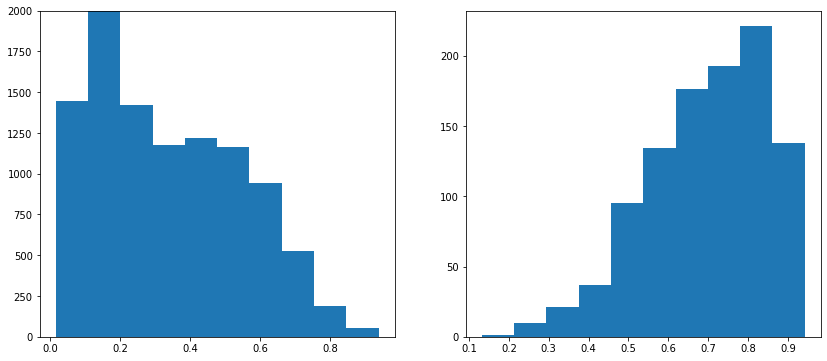

total error 0.6575816761363636
reduced val loss 0.02003
auc score 0.90865
elapsed time: 0mins 59s
new best score: 0.90865
saved model...
Epoch end Wed Jul  8 17:37:09 2020
---------------------------Epoch #1 ended--------------------------
--------------------------Epoch #2 started--------------------------
Epoch start Wed Jul  8 17:37:09 2020
----------------------------------------
Step	|	Time
----------------------------------------
(160)	|	Wed Jul  8 17:38:10 2020
(320)	|	Wed Jul  8 17:39:06 2020
(480)	|	Wed Jul  8 17:40:02 2020
(640)	|	Wed Jul  8 17:40:59 2020
----------------------------------------
finished training epoch 2
elapsed time: 4mins 13s
reduced loss 0.02288
finished validating epoch 2


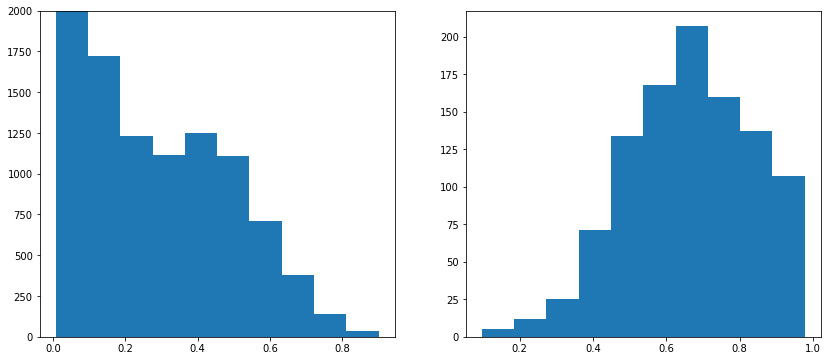

total error 0.580078125
reduced val loss 0.01945
auc score 0.91339
elapsed time: 1mins 0s
new best score: 0.91339
saved model...
Epoch end Wed Jul  8 17:42:23 2020
---------------------------Epoch #2 ended--------------------------
--------------------------Epoch #3 started--------------------------
Epoch start Wed Jul  8 17:42:23 2020
----------------------------------------
Step	|	Time
----------------------------------------
(160)	|	Wed Jul  8 17:43:23 2020
(320)	|	Wed Jul  8 17:44:19 2020
(480)	|	Wed Jul  8 17:45:15 2020
(640)	|	Wed Jul  8 17:46:11 2020
----------------------------------------
finished training epoch 3
elapsed time: 4mins 11s
reduced loss 0.02176
finished validating epoch 3


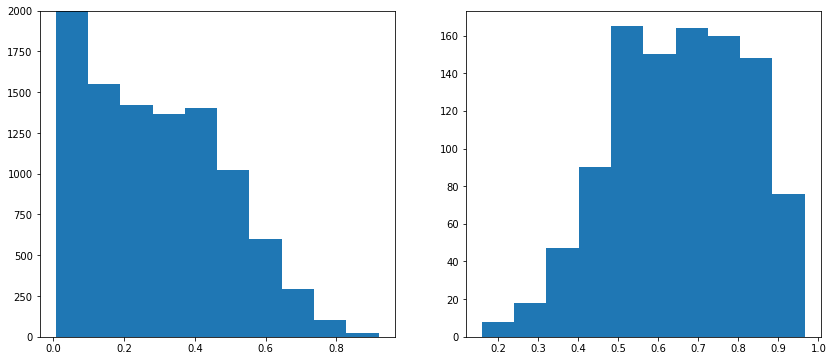

total error 0.6084872159090909
reduced val loss 0.01944
auc score 0.91444
elapsed time: 1mins 0s
new best score: 0.91444
saved model...
Epoch end Wed Jul  8 17:47:36 2020
---------------------------Epoch #3 ended--------------------------
--------------------------Epoch #4 started--------------------------
Epoch start Wed Jul  8 17:47:36 2020
----------------------------------------
Step	|	Time
----------------------------------------
(160)	|	Wed Jul  8 17:48:35 2020
(320)	|	Wed Jul  8 17:49:32 2020
(480)	|	Wed Jul  8 17:50:28 2020
(640)	|	Wed Jul  8 17:51:24 2020
----------------------------------------
finished training epoch 4
elapsed time: 4mins 12s
reduced loss 0.02101
finished validating epoch 4


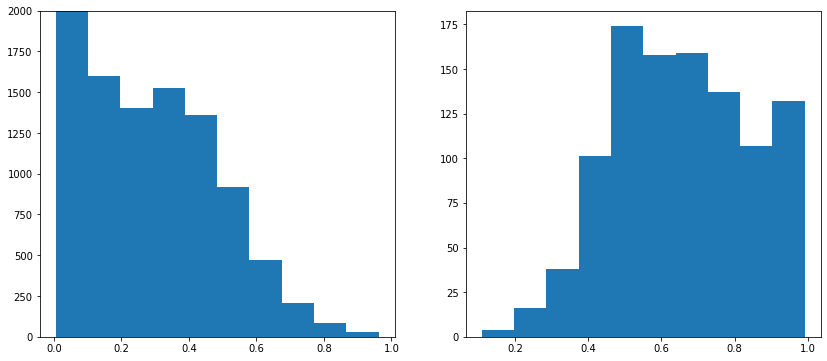

total error 0.5962357954545454
reduced val loss 0.02012
auc score 0.91035
elapsed time: 1mins 0s
saved model...
Epoch end Wed Jul  8 17:52:49 2020
---------------------------Epoch #4 ended--------------------------
--------------------------Epoch #5 started--------------------------
Epoch start Wed Jul  8 17:52:49 2020
----------------------------------------
Step	|	Time
----------------------------------------
(160)	|	Wed Jul  8 17:53:50 2020
(320)	|	Wed Jul  8 17:54:48 2020
(480)	|	Wed Jul  8 17:55:43 2020
(640)	|	Wed Jul  8 17:56:41 2020
----------------------------------------
finished training epoch 5
elapsed time: 4mins 16s
reduced loss 0.02056
finished validating epoch 5


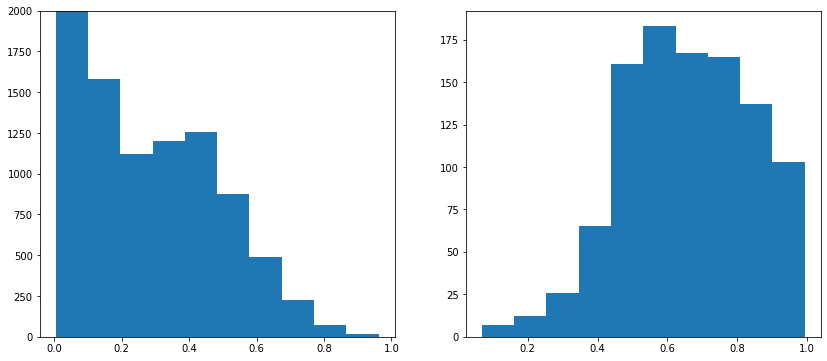

total error 0.5297407670454546
reduced val loss 0.01998
auc score 0.91501
elapsed time: 1mins 0s
new best score: 0.91501
saved model...
Epoch end Wed Jul  8 17:58:07 2020
---------------------------Epoch #5 ended--------------------------
--------------------------Epoch #6 started--------------------------
Epoch start Wed Jul  8 17:58:07 2020
----------------------------------------
Step	|	Time
----------------------------------------
(160)	|	Wed Jul  8 17:59:08 2020
(320)	|	Wed Jul  8 18:00:04 2020
(480)	|	Wed Jul  8 18:01:01 2020
(640)	|	Wed Jul  8 18:01:58 2020
----------------------------------------
finished training epoch 6
elapsed time: 4mins 15s
reduced loss 0.01986
finished validating epoch 6


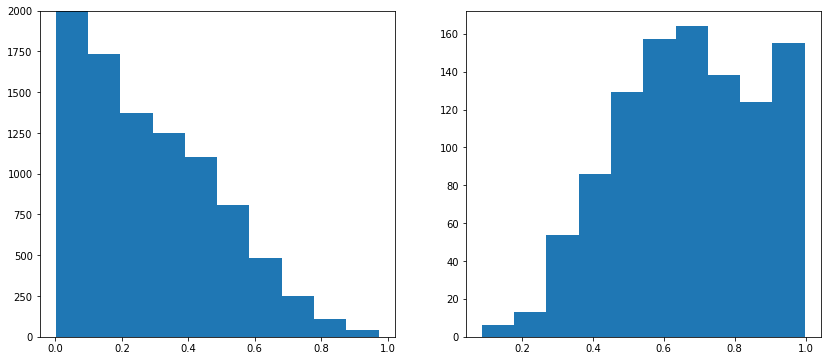

total error 0.5387961647727273
reduced val loss 0.02087
auc score 0.90886
elapsed time: 1mins 2s
Epoch end Wed Jul  8 18:03:24 2020
---------------------------Epoch #6 ended--------------------------
--------------------------Epoch #7 started--------------------------
Epoch start Wed Jul  8 18:03:24 2020
----------------------------------------
Step	|	Time
----------------------------------------
(160)	|	Wed Jul  8 18:04:21 2020
(320)	|	Wed Jul  8 18:05:17 2020
(480)	|	Wed Jul  8 18:06:15 2020
(640)	|	Wed Jul  8 18:07:13 2020
----------------------------------------
finished training epoch 7
elapsed time: 4mins 12s
reduced loss 0.01980
finished validating epoch 7
Epoch     7: reducing learning rate of group 0 to 1.0000e-04.
Epoch     7: reducing learning rate of group 0 to 1.0000e-04.
Epoch     7: reducing learning rate of group 0 to 1.0000e-04.
Epoch     7: reducing learning rate of group 0 to 1.0000e-04.
Epoch     7: reducing learning rate of group 0 to 1.0000e-04.
Epoch     7: reduc

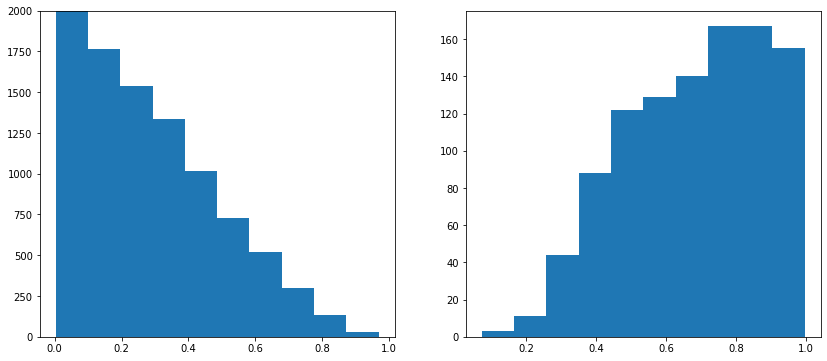

total error 0.5526455965909091
reduced val loss 0.02030
auc score 0.91205
elapsed time: 1mins 0s
saved model...
Epoch end Wed Jul  8 18:08:38 2020
---------------------------Epoch #7 ended--------------------------
--------------------------Epoch #8 started--------------------------
Epoch start Wed Jul  8 18:08:38 2020
----------------------------------------
Step	|	Time
----------------------------------------
(160)	|	Wed Jul  8 18:09:37 2020
(320)	|	Wed Jul  8 18:10:32 2020
(480)	|	Wed Jul  8 18:11:27 2020


In [ ]:
FLAGS = {}
FLAGS['batch_size'] = 8
FLAGS['num_workers'] = 8
FLAGS['learning_rate'] = 0.25e-4
FLAGS['num_epochs'] = 20
FLAGS['weight_decay'] = 1e-3
FLAGS['log_steps'] = 20 * 8
FLAGS['img_size'] = IMG_SIZE # 224
FLAGS['loss'] = 'focal'
FLAGS['alpha'] = (41906 / (41906 + 3874)) #0.9153778942769768
FLAGS['gamma'] = 1.65
FLAGS['optimizer'] = 'AdamW'
FLAGS['scheduler'] = 'ReduceLROnPlateau'
FLAGS['exp_name'] = 'enet_b0'
FLAGS['fold'] = [0] # , 1, 2, 3, 4]
FLAGS['val_freq'] = 1
FLAGS['num_cores'] = 8
FLAGS['seed'] = 43

model_cpu = EfficientNet('tf_efficientnet_b0_ns')
#model.load_state_dict(torch.load(''))
WRAPPED_MODEL = xmp.MpModelWrapper(model_cpu)
SERIAL_EXEC = xmp.MpSerialExecutor()

#y_train = pd.get_dummies(df_train[df_train['fold'] != fold_no][[col for col in df_train.columns if col == 'target']], columns=['target'])
#y_val = pd.get_dummies(df_train[df_train['fold'] == fold_no][[col for col in df_train.columns if col == 'target']], columns=['target'])

for fold_no in FLAGS['fold']:
    X_train = df_train[df_train['fold'] != fold_no][[col for col in df_train.columns if col != 'target']]
    X_val = df_train[df_train['fold'] == fold_no][[col for col in df_train.columns if col != 'target']]
    y_train = df_train[df_train['fold'] != fold_no][[col for col in df_train.columns if col == 'target']]
    y_val = df_train[df_train['fold'] == fold_no][[col for col in df_train.columns if col == 'target']]
    data = X_train, y_train, X_val, y_val
    xmp.spawn(
        _mp_fn, args=(FLAGS, data, fold_no, True),
        nprocs=FLAGS['num_cores'], start_method='fork'
    )


In [18]:
#!rm -rf ./runs/

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir ./runs/

## Inference

In [ ]:
class MelanomaTestDataset(Dataset):

    def __init__(self, df, transforms=None):
        super().__init__()
        self.image_id = df['image_id'].values
        self.transforms = transforms

    def __len__(self):
        return len(self.image_id)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        
        image = self.load_image(index)

        if self.transforms:
            image = self.transforms(image=image)['image']

        return image

    def load_image(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        image_name = DATA_DIR + f'512x512-test/512x512-test/{self.image_id[index]}.jpg'
        #image_name = DATA_DIR + f'512x512-dataset-melanoma/512x512-dataset-melanoma/{self.image_id[index]}.jpg'
        image = cv2.imread(image_name, cv2.IMREAD_COLOR).astype(np.uint8)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.uint8)
        return image


In [ ]:
def run_test(model, test_images, ckpts):
    device = 'cpu'
    agg_predictions = []
    for ckpt in ckpts:
        model.load_state_dict(torch.load(ckpt))
        model.to(device)
        model.eval()
        test_dataset = MelanomaTestDataset(test_images, transforms=get_valid_transforms())
        test_data_loader = DataLoader(
            test_dataset, batch_size=64, shuffle=False, 
            num_workers=16, pin_memory=True
        )
        predictions = []
        with torch.no_grad():
            for images in tqdm(test_data_loader, total=len(test_data_loader)):
                images = images.to(device)
                y_pred = torch.sigmoid(model(images.float()))
                predictions.append(y_pred.cpu().numpy())
        predictions = np.vstack(predictions)
        plt.hist(predictions.T[0],bins=100)
        plt.ylim((0,500))
        plt.show()
        agg_predictions.append(predictions)

    avg_predictions = 0
    for predictions in agg_predictions:
        #avg_predictions = np.multiply(avg_predictions, predictions).astype(np.float64)
        avg_predictions = np.add(avg_predictions, predictions).astype(np.float64)
    #avg_predictions = np.power(avg_predictions, (1/float(len(agg_predictions))))
    avg_predictions = np.divide(avg_predictions, float(len(agg_predictions)))
    print('average:')
    plt.hist(avg_predictions.T[0], bins=100)
    plt.ylim((0,500))
    plt.show()
    return avg_predictions

### Infer

In [ ]:
model_cpu = EfficientNet('tf_efficientnet_b0_ns')
ckpts = [
         '/content/enet_b0_fold_2_epoch_19_auc_0.94426.pth',
         '/content/enet_b0_fold_2_epoch_24_auc_0.94186.pth',
         ]
avg_predictions = run_test(model_cpu, df_test, ckpts)

In [ ]:
pd.Series(avg_predictions.T[0]).describe()

# count    10982.000000
# mean         0.138004
# std          0.138120
# min          0.009435
# 25%          0.055362
# 50%          0.090186
# 75%          0.163873
# max          0.969424


In [ ]:
pd.Series(np.where(avg_predictions>0.5,1,0).T[0]).value_counts()

In [ ]:
sample_submission = pd.read_csv(DATA_DIR+'sample_submission.csv')
sample_submission.target = avg_predictions.T[0].T
sample_submission.to_csv('submission.csv', index=False)

In [ ]:
pd.read_csv('submission.csv')

### Submit to Kaggle

In [ ]:
!kaggle competitions submit -c siim-isic-melanoma-classification -f submission.csv -m 'EffNet_B0 focal CV0.94+ fold 1 epoch 19, 24'

In [ ]:
!kaggle competitions submissions siim-isic-melanoma-classification